In [2]:
import pandas as pd

# Sogood

## Random companies

In [281]:
import pandas as pd
import numpy as np
import random 
matches_df = pd.read_csv('../datasets/ai_mentions.csv')
random_companies = matches_df[(matches_df.reporting_year==2024) & (matches_df.match_field=='1A_matches')].drop_duplicates('cik').cik.sample(n=20, random_state=42)

business_mention_companies = matches_df[(matches_df.match_field=='1_matches') & (matches_df.reporting_year==2024)].cik
first_risk = matches_df[(~matches_df.cik.isin(business_mention_companies)) & (matches_df.match_field=='1A_matches')].groupby('cik')[['reporting_year']].min()
random_risk_no_business = first_risk[first_risk.reporting_year==2024].sample(n=20, random_state=42).index

random_statemments = matches_df.drop_duplicates('sentence').sample(n=385, random_state=42)
top_10 = [1652044, 1136101, 1326801, 1018724, 789019, 1045810, 320193, 1318605, 1730168, 1065280, 1341439]


In [123]:
bram_labels = pd.read_excel('../datasets/labels/sogood_bram_ai_mentions.xlsx')
lucas_labels = pd.read_excel('../datasets/labels/sogood_lucas_ai_mentions.xlsx')

In [145]:
label_columns = ['Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP',
       'Other legal', 'Rapid developments', 'Large investments',
       'Other competitive', 'Reputational', 'Societal']

In [146]:
lucas_labeled =lucas_labels[(lucas_labels.reporting_year == 2024) & (lucas_labels.match_field=='1A_matches') & ((lucas_labels.top_10==1) | (lucas_labels.cik.isin(random_risk_no_business)) | (lucas_labels.cik.isin(random_companies)))]
lucas_nvidia_2025 = lucas_labels[(lucas_labels.reporting_year== 2025) & (lucas_labels.cik==1045810) & (lucas_labels.match_field=='1A_matches')]
lucas_labeled_without_nvidia = lucas_labeled[lucas_labeled.cik != 1045810]
lucas_labeled_complete = pd.concat([lucas_labeled_without_nvidia, lucas_nvidia_2025], ignore_index=True)
lucas_labeled_complete[label_columns] = lucas_labeled_complete[label_columns].fillna(0).astype(int)

In [147]:
bram_labeled =bram_labels[(bram_labels.reporting_year == 2024) & (bram_labels.match_field=='1A_matches') & ((bram_labels.top_10==1) | (bram_labels.cik.isin(random_risk_no_business)) | (bram_labels.cik.isin(random_companies)))]
bram_nvidia_2025 = bram_labels[(bram_labels.reporting_year== 2025) & (bram_labels.cik==1045810) & (bram_labels.match_field=='1A_matches')]
bram_labeled_without_nvidia = bram_labeled[bram_labeled.cik != 1045810]
bram_labeled_complete = pd.concat([bram_labeled_without_nvidia, bram_nvidia_2025], ignore_index=True)
bram_labeled_complete[label_columns] = bram_labeled_complete[label_columns].fillna(0).astype(int)


In [148]:
joined_labeled_complete = bram_labeled_complete.join(lucas_labeled_complete, rsuffix='_lucas', lsuffix='_bram')

In [127]:
either_societal = joined_labeled_complete[(joined_labeled_complete.Societal_lucas==1) | (joined_labeled_complete.Societal_bram==1)]
either_societal.to_excel('../datasets/labels/sogood_combined_societal_mentions.xlsx')

## Non societal disagreements

In [149]:
non_societal = joined_labeled_complete[~((joined_labeled_complete.Societal_lucas==1) | (joined_labeled_complete.Societal_bram==1))]

In [150]:
# Extract all rows where any of the Lucas label columns has a different value than the respective Bram label column
differing_rows_condition = False
for col in label_columns:
    bram_col = f"{col}_bram"
    lucas_col = f"{col}_lucas"
    differing_rows_condition |= (non_societal[bram_col] != non_societal[lucas_col])

# Select rows where labels differ
differing_rows = non_societal.fillna(0)[differing_rows_condition]

In [166]:
len(non_societal)

521

In [167]:
len(differing_rows)

273

In [155]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.utils.dataframe import dataframe_to_rows

# Method 1: Using openpyxl for detailed formatting
def export_with_highlighting(df, filename='label_differences.xlsx'):
    # Export to Excel first
    df.to_excel(filename, index=False)
    
    # Load the workbook and worksheet
    wb = load_workbook(filename)
    ws = wb.active
    
    # Define highlighting styles
    highlight_fill = PatternFill(start_color="FFFF00", end_color="FFFF00", fill_type="solid")  # Yellow
    bold_font = Font(bold=True)
    
    # Get column indices for Bram and Lucas columns
    column_indices = {}
    for idx, col_name in enumerate(df.columns, 1):  # Excel columns start at 1
        column_indices[col_name] = idx
    
    # Iterate through each row (starting from row 2, since row 1 is headers)
    for row_idx in range(2, len(df) + 2):
        df_row_idx = row_idx - 2  # Corresponding DataFrame row index
        
        # Check each label column pair
        for col in label_columns:
            bram_col = f"{col}_bram"
            lucas_col = f"{col}_lucas"
            
            # Check if these columns exist and values differ
            if (bram_col in df.columns and lucas_col in df.columns and
                bram_col in column_indices and lucas_col in column_indices):
                
                bram_val = df.iloc[df_row_idx][bram_col]
                lucas_val = df.iloc[df_row_idx][lucas_col]
                
                if pd.notna(bram_val) and pd.notna(lucas_val) and bram_val != lucas_val:
                    # Highlight both cells
                    bram_cell = ws.cell(row=row_idx, column=column_indices[bram_col])
                    lucas_cell = ws.cell(row=row_idx, column=column_indices[lucas_col])
                    
                    bram_cell.fill = highlight_fill
                    lucas_cell.fill = highlight_fill
                    bram_cell.font = bold_font
                    lucas_cell.font = bold_font
    
    # Save the formatted workbook
    wb.save(filename)
    print(f"Excel file saved as '{filename}' with highlighted differences")


In [157]:
lucas_labeled_complete.columns

Index(['sentence', 'company', 'keyword', 'match_field', 'cik', 'filing_date',
       'period_of_report', 'filename', 'match_id', 'filing_year',
       'reporting_year', 'top_10', 'random_risk_no_business', 'random',
       'Who uses it? (us/others)', 'Business mention interesting? ',
       'Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP',
       'Other legal', 'Rapid developments', 'Large investments',
       'Other competitive', 'Reputational', 'Societal', 'Domain', 'Sub-domain',
       'Not an AI risk', 'Labeled', 'Quotationable'],
      dtype='object')

In [ ]:
core_columns = ['match_id_bram', 'sentence_bram', 'company_bram', 'keyword_bram', 'cik_bram', 'reporting_year_bram']
relevant_columns = core_columns.copy()
for col in label_columns:
    relevant_columns.append(f"{col}_bram")
    relevant_columns.append(f"{col}_lucas")

differing_rows = non_societal[differing_rows_condition][relevant_columns]
differing_rows = differing_rows.rename(columns={k:k.replace('_bram', '') for k in core_columns})
# export_with_highlighting(differing_rows, filename='../datasets/labels/sogood_nonsocietal_label_differences.xlsx')

Excel file saved as '../datasets/labels/sogood_nonsocietal_label_differences.xlsx' with highlighted differences


### Combining labels

In [260]:
societal_labels = pd.read_excel('../datasets/labels/sogood_combined_societal_mentions.xlsx')
societal_labels = societal_labels.rename(columns={'us_others': 'Who uses it? (us/others)'})
non_societal_labels = pd.read_excel('../datasets/labels/sogood_nonsocietal_label_differences.xlsx')
non_societal_labels['sentence number'] = list(differing_rows.index)
non_societal_labels = non_societal_labels[[i for i in non_societal_labels.columns if not i.endswith('_lucas')]]
non_societal_labels = non_societal_labels.rename(columns={k:k.replace('_bram', '') for k in non_societal_labels.columns if k.endswith('_bram')}).set_index('sentence number')
all_others = non_societal.fillna(0)[~differing_rows_condition]

In [261]:
relable_missing_columns = ['match_field', 'filing_date', 'period_of_report', 'filename', 'filing_year', 'top_10', 'random_risk_no_business', 'random', 'Who uses it? (us/others)', 'Domain', 'Sub-domain', 'Not an AI risk', 'Quotationable']
non_societal_relabeled = non_societal_labels.join(non_societal[[f"{i}_bram" for i in relable_missing_columns]])
non_societal_relabeled = non_societal_relabeled.rename(columns={k:k.replace('_bram', '') for k in non_societal_relabeled.columns if k.endswith('_bram')})

In [262]:
all_others = all_others[[f"{col}_bram" for col in non_societal_relabeled.columns]]
all_others = all_others.rename(columns={k:k.replace('_bram', '') for k in all_others.columns if k.endswith('_bram')}) 

In [271]:
total_combined = pd.concat([societal_labels, non_societal_relabeled, all_others.reset_index(names='sentence number')])

In [272]:
total_combined.to_excel('../datasets/labels/sogood_final_combined_labels.xlsx', index=False)

In [282]:
total_combined.loc[total_combined.cik.isin(random_companies),'group' ] = 'random_companies'
total_combined.loc[total_combined.cik.isin(random_risk_no_business),'group' ] = 'random_risk_no_business'
total_combined.loc[total_combined.cik.isin(top_10),'group' ] = 'top_10'

## Inter-annotator agreement

In [485]:
!pip install scikit-learn

  Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.3.2-cp38-cp38-win_amd64.whl (9.3 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/42.2 MB ? eta -:--:--
   -- ------------------------------------- 2.6/42.2 MB 16.9 MB/s eta 0:00:03
   ------ --------------------------------- 6.8/42.2 MB 18.3 MB/s eta 0:00:02
   --------- ------------------------------ 10.5/42.2 MB 18.7 MB/s eta 0:00:02
   ------------- -------------------------- 14.2/42.2 MB 18.5 MB/s eta 0:00:02
   ---------------- ----------------------- 17.3/42.2 MB 17.9 MB/s eta 0:00:02
   ------------------- -------------------- 20.4/42.2 MB 17.5 MB/s eta 0:00:02
   ---------------------- ----------------- 23.6/42.2 MB 17.0 MB/s eta 0:00:02
   ------------------------ --------------- 26.2/42.2 M

In [486]:
from sklearn.metrics import cohen_kappa_score

In [496]:
legal_labels = ['Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP', 'Other legal']
competition_labels = ['Rapid developments', 'Large investments', 'Other competitive']

In [511]:
kappas = {}
for label in label_columns:
    lucas_label = joined_labeled_complete[f"{label}_lucas"]
    bram_label = joined_labeled_complete[f"{label}_bram"]
    # print(f"Agreement for label {label} was {joined_labeled_complete[lucas_label==bram_label].shape[0]/len(joined_labeled_complete)}%")
    kappa = cohen_kappa_score(lucas_label, bram_label)
    print(f"For label {label} Cohen's kappa was {kappa:.2f}, agreement was {joined_labeled_complete[lucas_label==bram_label].shape[0]/len(joined_labeled_complete)*100:.2f}%")
    kappas[label] = kappa

# Aggregated per group 
lucas_legal = joined_labeled_complete[[f"{col}_lucas" for col in legal_labels]].max(axis=1)
bram_legal = joined_labeled_complete[[f"{col}_bram" for col in legal_labels]].max(axis=1)
legal_kappa = cohen_kappa_score(lucas_legal, bram_legal)
print(f"For legal category, Cohen's kappa was {legal_kappa}, agreement was {(lucas_legal==bram_legal).sum()*100/len(lucas_legal):.2f}%")
kappas['legal'] = legal_kappa

lucas_competitive = joined_labeled_complete[[f"{col}_lucas" for col in competition_labels]].max(axis=1)
bram_competitive = joined_labeled_complete[[f"{col}_bram" for col in competition_labels]].max(axis=1)
competition_kappa = cohen_kappa_score(lucas_competitive, bram_competitive)
print(f"For competitive category, Cohen's kappa was {competition_kappa}, agreement was {(lucas_competitive==bram_competitive).sum()*100/len(lucas_competitive):.2f}%")
kappas['competition'] = competition_kappa


For label Compliance costs Cohen's kappa was 0.48, agreement was 91.53%
For label Legal uncertainty Cohen's kappa was 0.49, agreement was 88.93%
For label Legal actions Cohen's kappa was 0.62, agreement was 93.03%
For label IP Cohen's kappa was 0.71, agreement was 96.17%
For label Other legal Cohen's kappa was 0.27, agreement was 85.38%
For label Rapid developments Cohen's kappa was 0.58, agreement was 93.17%
For label Large investments Cohen's kappa was 0.57, agreement was 95.63%
For label Other competitive Cohen's kappa was 0.46, agreement was 81.28%
For label Reputational Cohen's kappa was 0.75, agreement was 95.49%
For label Societal Cohen's kappa was 0.82, agreement was 93.31%
For legal category, Cohen's kappa was 0.7964640730356605, agreement was 90.16%
For competitive category, Cohen's kappa was 0.6042413091895033, agreement was 81.69%


In [531]:
total_combined[total_combined['Not an AI risk'] != True].groupby('cik').sentence.nunique().sum()

444

# Table per subgroup
Showing the percentage of companies with at least one statement of each of the categories (considering societal a simple 1/0). Also breakdown per typeof societal. 

In [289]:
label_columns = ['Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP',
       'Other legal', 'Rapid developments', 'Large investments',
       'Other competitive', 'Reputational', 'Societal']

Per label

In [ ]:
companies_per_label = {}
for label in label_columns:
    companies_per_label[label] = total_combined.groupby(['cik', 'group'])[[label]].max().reset_index().groupby(['group', label]).size()
companies_per_label_df = pd.concat(companies_per_label.values(), axis=1).rename(columns={i:v for i,v in enumerate(companies_per_label.keys())})


Per grouped label

In [334]:
legal_labels = ['Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP', 'Other legal']
competition_labels = ['Rapid developments', 'Large investments', 'Other competitive']
reputational_labels = ['Reputational']

legal_risks = (total_combined.groupby(['cik', 'group'])[legal_labels].max().sum(axis=1)>0).reset_index().rename(columns={0:'legal_risk'}).groupby([ 'legal_risk', 'group']).size()
competitive_risks = (total_combined.groupby(['cik', 'group'])[competition_labels].max().sum(axis=1)>0).reset_index().rename(columns={0:'competitive_risk'}).groupby([ 'competitive_risk', 'group']).size()

grouped_companies_per_label_df = pd.concat([competitive_risks, legal_risks, companies_per_label['Reputational'],  companies_per_label['Societal']], axis=1).rename(columns={1:'legal', 0:'competitive', 2:'reputational', 3:'societal'}).fillna(0).astype(int)

In [345]:
number_of_unique_sentences = total_combined.groupby('group')[['sentence']].nunique()

Per type of sub-domain

In [360]:
per_subdomain = total_combined[total_combined['Sub-domain']!=0].groupby(['Sub-domain', 'group'])[['cik']].nunique()

In [362]:
per_domain = total_combined[total_combined['Domain']!=0].groupby(['Domain', 'group'])[['cik']].nunique()

In [520]:
number_of_sentences_per_group_per_label = total_combined.groupby(['group']).sum().iloc[:, 7:-1]

C:\Users\P70088982\AppData\Local\Temp\ipykernel_21280\1689197222.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  number_of_sentences_per_group_per_label = total_combined.groupby(['group']).sum().iloc[:, 7:-1]


In [521]:
# Export to excel sheet
sheets = {'companies_per_label': companies_per_label_df, 'grouped_companies_per_label': grouped_companies_per_label_df, 
          'number_of_unique_sentences': number_of_unique_sentences, 'per_subdomain': per_subdomain,
          'per_domain': per_domain, 'number_of_sentences_per_group_per_label': number_of_sentences_per_group_per_label}
with pd.ExcelWriter('../datasets/labels/companies_per_label.xlsx') as writer:
    for label, counts in sheets.items():
        counts.to_excel(writer, sheet_name=label, index=True)

c:\Users\P70088982\AppData\Local\miniconda3\envs\edgar_crawler\lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Plots

In [377]:
import seaborn as sns

In [ ]:
grouped_companies_per_label_df_norm = grouped_companies_per_label_df/20

grouped_companies_per_label_df_norm.loc[(slice(None), 'top_10'), :] = grouped_companies_per_label_df_norm *2
grouped_companies_per_label_df_norm = grouped_companies_per_label_df_norm.reset_index().rename(columns={'level_0': 'mentioned'})
grouped_companies_per_label_df_norm = grouped_companies_per_label_df_norm[grouped_companies_per_label_df_norm.mentioned]
grouped_companies_per_label_df_norm = grouped_companies_per_label_df_norm.melt(id_vars=['mentioned', 'group'], value_vars=['legal', 'competitive', 'reputational', 'societal'])


In [400]:
grouped_companies_per_label_df_norm

,mentioned,group,variable,value
0,True,random_companies,legal,0.50
1,True,random_risk_no_business,legal,0.50
2,True,top_10,legal,1.00
3,True,random_companies,competitive,0.55
4,True,random_risk_no_business,competitive,0.70
5,True,top_10,competitive,0.90
6,True,random_companies,reputational,0.30
7,True,random_risk_no_business,reputational,0.15
8,True,top_10,reputational,0.70
9,True,random_companies,societal,0.85


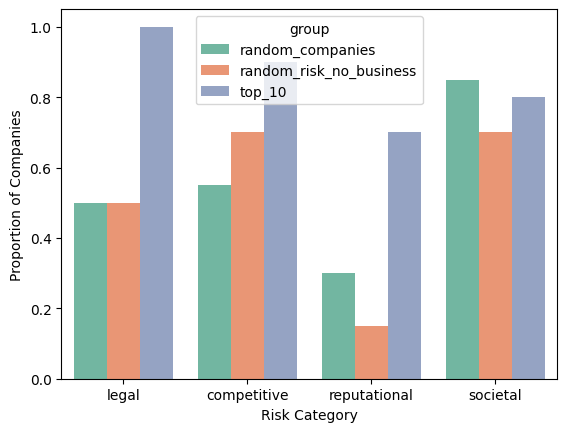

In [466]:
sns.barplot(data = grouped_companies_per_label_df_norm, x='variable', y='value', hue='group', palette='Set2')
# relabel axes 
import matplotlib.pyplot as plt
plt.xlabel('Risk Category')
plt.ylabel('Proportion of Companies')
plt.savefig('../figures/companies_per_label_plot.jpg', dpi=300)

In [432]:
granular_companies_per_label_df_norm = companies_per_label_df.iloc[:, :8]/20

granular_companies_per_label_df_norm.loc[(slice(None), 'top_10'), :] = granular_companies_per_label_df_norm *2
granular_companies_per_label_df_norm = granular_companies_per_label_df_norm.reset_index().rename(columns={'level_0': 'mentioned'})
granular_companies_per_label_df_norm = granular_companies_per_label_df_norm[granular_companies_per_label_df_norm.mentioned==1]
granular_companies_per_label_df_norm = granular_companies_per_label_df_norm.melt(id_vars=['mentioned', 'group'], value_vars=['Compliance costs', 'Legal uncertainty', 'Legal actions', 'IP', 'Other legal', "Rapid developments", "Large investments", "Other competitive"])


In [433]:
granular_companies_per_label_df_norm.loc[granular_companies_per_label_df_norm.variable.isin(legal_labels), 'risk_type'] = 'Legal Risks'
granular_companies_per_label_df_norm.loc[granular_companies_per_label_df_norm.variable.isin(competition_labels), 'risk_type'] = 'Competitive Risks'

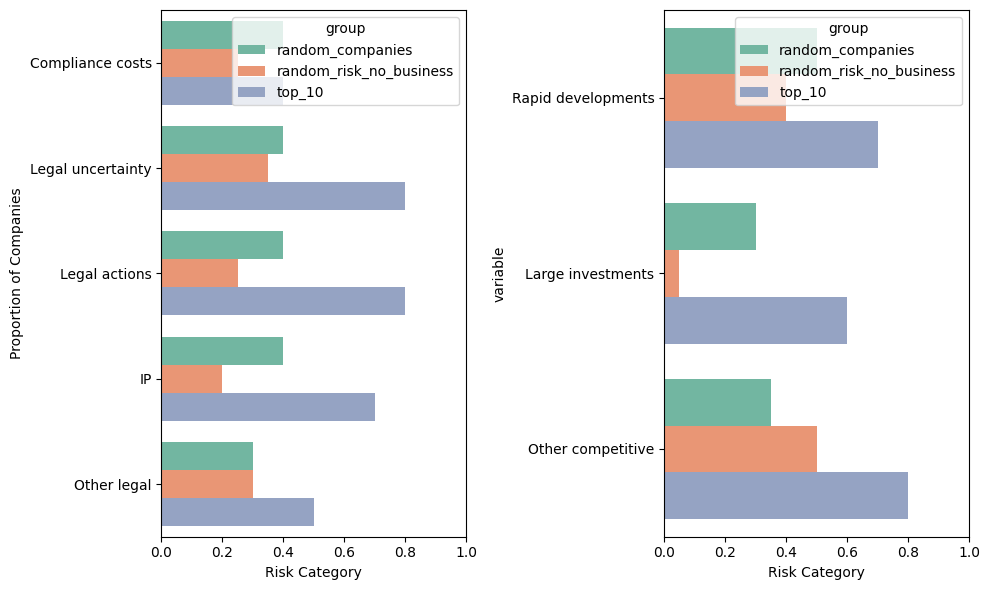

In [479]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
sns.barplot(data = granular_companies_per_label_df_norm[granular_companies_per_label_df_norm.risk_type=='Legal Risks'], y='variable', x='value', hue='group', palette='Set2', ax=ax[0])
sns.barplot(data = granular_companies_per_label_df_norm[granular_companies_per_label_df_norm.risk_type=='Competitive Risks'], y='variable', x='value', hue='group', palette='Set2', ax=ax[1])
# relabel axes 
import matplotlib.pyplot as plt
ax[0].set_xlabel('Risk Category')
ax[1].set_xlabel('Risk Category')
ax[0].set_ylabel('Proportion of Companies')
ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

# Disble legend 
plt.tight_layout()
# Rotate x-axis labels
plt.savefig('../figures/companies_per_sublabel.jpg', dpi=300)

In [470]:
granular_companies_per_domain_df_norm = per_domain/20

granular_companies_per_domain_df_norm.loc[(slice(None), 'top_10'), :] = granular_companies_per_domain_df_norm *2
granular_companies_per_domain_df_norm = granular_companies_per_domain_df_norm.reset_index().rename(columns={'level_0': 'mentioned'})

In [472]:
granular_companies_per_domain_df_norm

,Domain,group,cik
0,1. Discrimination & Toxicity,random_companies,0.30
1,1. Discrimination & Toxicity,random_risk_no_business,0.15
2,1. Discrimination & Toxicity,top_10,0.30
3,2. Privacy & Security,random_companies,0.35
4,2. Privacy & Security,random_risk_no_business,0.40
5,2. Privacy & Security,top_10,0.40
6,3. Misinformation,random_companies,0.10
7,3. Misinformation,top_10,0.50
8,4. Malicious Actors & Misuse,random_companies,0.60
9,4. Malicious Actors & Misuse,random_risk_no_business,0.60


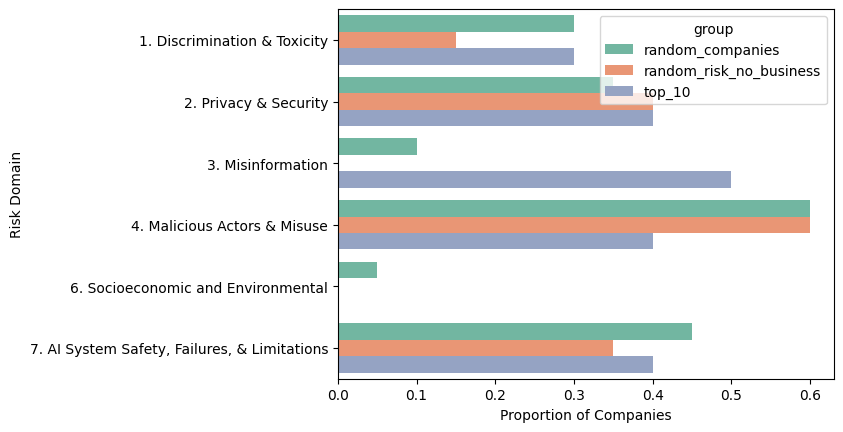

In [478]:
sns.barplot(data = granular_companies_per_domain_df_norm, y='Domain', x='cik', hue='group', palette='Set2')
# relabel axes 
import matplotlib.pyplot as plt
plt.ylabel('Risk Domain')
plt.xlabel('Proportion of Companies')
plt.savefig('../figures/companies_per_domain_plot.jpg', dpi=300)

# Leuven

In [79]:
bram_labels = pd.read_excel('../datasets/labels/final_bram_ai_mentions.xlsx')
lucas_labels = pd.read_excel('../datasets/labels/final_lucas_ai_mentions.xlsx')

In [82]:
bram_actual_labels = bram_labels[(bram_labels.top_10==True) & ((bram_labels.reporting_year==2025)|((bram_labels.reporting_year==2024) & (bram_labels.cik != 1045810))) & (bram_labels.match_field=='1A_matches') ].drop_duplicates(subset= ['sentence', 'cik'])
lucas_actual_labels = lucas_labels[(lucas_labels.top_10==True) & ((lucas_labels.reporting_year==2025)|((lucas_labels.reporting_year==2024) & (lucas_labels.cik != 1045810))) & (lucas_labels.match_field=='1A_matches') ].drop_duplicates(subset=[ 'sentence', 'cik'])

In [93]:
# 38 societal risks 
38/ len(bram_actual_labels[bram_actual_labels["Not an AI risk"] ==0])

0.2111111111111111

In [71]:
combined_labels = bram_actual_labels.join(lucas_actual_labels, lsuffix='_bram', rsuffix='_lucas', how='inner')

In [72]:
# Comparison between bram and lucas labels
legal = combined_labels['Legal_bram'] == combined_labels['Legal_lucas']
competitive = combined_labels['Competitive_bram'] == combined_labels['Competitive_lucas']
reputational = combined_labels['Reputational_bram'] == combined_labels['Reputational_lucas']
societal = combined_labels['Societal_bram'] == combined_labels['Societal_lucas']

In [73]:
print(f"The agreement in legal labels is {legal.sum()/len(legal)*100:.2f}%")
print(f"The agreement in competitive labels is {competitive.sum()/len(competitive)*100:.2f}%")
print(f"The agreement in reputational labels is {reputational.sum()/len(reputational)*100:.2f}%")
print(f"The agreement in societal labels is {societal.sum()/len(societal)*100:.2f}%")

The agreement in legal labels is 90.00%
The agreement in competitive labels is 65.00%
The agreement in reputational labels is 90.00%
The agreement in societal labels is 91.00%


In [74]:
print(f"For Lucas' labels, there are {combined_labels.Legal_lucas.sum()/len(combined_labels)*100:.2f}% legal mentions, {combined_labels.Competitive_lucas.sum()/len(combined_labels)*100:.2f}% competitive mentions, {combined_labels.Reputational_lucas.sum()/len(combined_labels)*100:.2f}% reputational mentions and {combined_labels.Societal_lucas.sum()/len(combined_labels)*100:.2f}% societal mentions, and {combined_labels['Not an AI risk_lucas'].sum()/len(combined_labels)*100:.2f}% mentions that are not an AI risk.")
print(f"For Bram's labels, there are {combined_labels.Legal_bram.sum()/len(combined_labels)*100:.2f}% legal mentions, {combined_labels.Competitive_bram.sum()/len(combined_labels)*100:.2f}% competitive mentions, {combined_labels.Reputational_bram.sum()/len(combined_labels)*100:.2f}% reputational mentions and {combined_labels.Societal_bram.sum()/len(combined_labels)*100:.2f}% societal mentions, and {combined_labels['Not an AI risk_bram'].sum()/len(combined_labels)*100:.2f}% mentions that are not an AI risk.")

For Lucas' labels, there are 39.50% legal mentions, 27.50% competitive mentions, 13.50% reputational mentions and 15.00% societal mentions, and 30.50% mentions that are not an AI risk.
For Bram's labels, there are 44.50% legal mentions, 49.50% competitive mentions, 14.50% reputational mentions and 18.00% societal mentions, and 10.00% mentions that are not an AI risk.


In [75]:
societal.to_excel('../datasets/labels/combined_societal_mentions.xlsx', index=False)